<h1>Neural network Modeling</h1>

In [398]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import yfinance as yf
import torch.optim as optim
import torch.functional as F
#from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
#from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import warnings
import os
warnings.filterwarnings("ignore")
from pathlib import Path
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import tempfile
from functools import partial

<H2>Gather data of Ethereum stock tickers</H2>

In [399]:
#skip ticker generation if it's present in the folder. Yahoo sometimes is too heavily occupied and cannot answer
path = './data/prices/ticker.csv'

if not os.path.isfile(path):
    tck = yf.Ticker("ETH-USD")
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    df = tck.history(start=start_date, end=end_date)
    df.to_csv('./data/prices/ticker.csv', index=False)
else:
    df = pd.read_csv(path)

In [400]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,737.708374,749.201843,719.792236,730.367554,13652004358,0.0,0.0
1,730.402649,786.798462,718.109497,774.534973,19740771179,0.0,0.0
2,774.511841,1006.565002,771.561646,975.507690,45200463368,0.0,0.0
3,977.058838,1153.189209,912.305359,1040.233032,56945985763,0.0,0.0
4,1041.498779,1129.371460,986.811279,1100.006104,41535932781,0.0,0.0


In [401]:
#use only if first block fails for some reason
#df.to_csv('./data/prices/ticker.csv', index=False)

In [402]:
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
0,730.367554,737.708374,749.201843,719.792236,13652004358,0.0,0.0
1,774.534973,730.402649,786.798462,718.109497,19740771179,0.0,0.0
2,975.507690,774.511841,1006.565002,771.561646,45200463368,0.0,0.0
3,1040.233032,977.058838,1153.189209,912.305359,56945985763,0.0,0.0
4,1100.006104,1041.498779,1129.371460,986.811279,41535932781,0.0,0.0


<h2>Drop the dividends and Stock Splits columns. We don't include them in our analysis.</h2>

In [403]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df['Volume'] = df['Volume'].astype('float64')
columns=['Close', 'Open', 'High', 'Low', 'Volume']
df.columns == columns

array([ True,  True,  True,  True,  True])

<h2>Plot to check for missing data</h2>

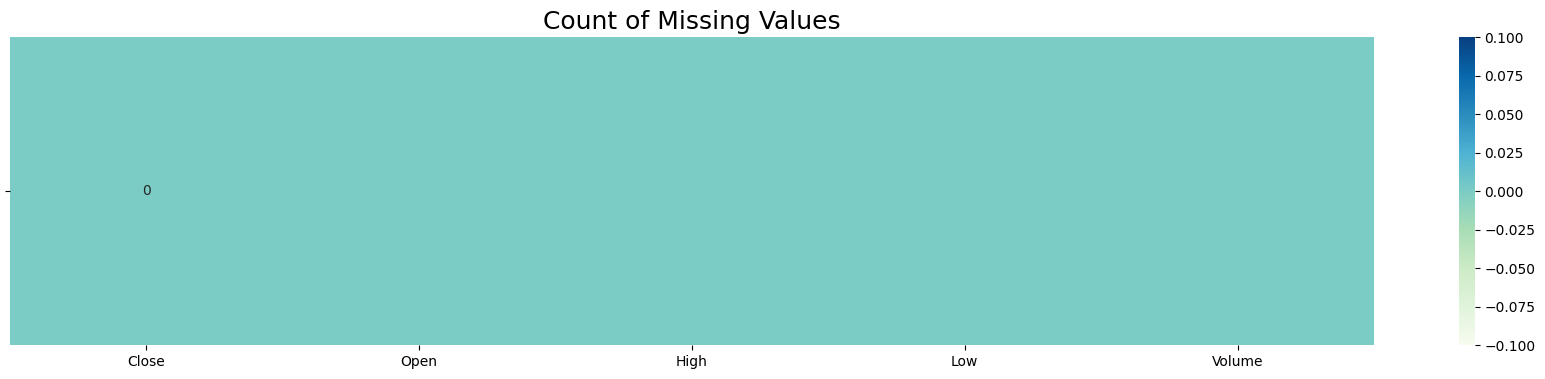

In [404]:
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [405]:
df.describe().T.style.background_gradient(cmap='GnBu', axis=1)

,count,mean,std,min,25%,50%,75%,max
Close,365.000000,2778.354149,1023.543690,730.367554,1895.552124,2633.518311,3638.122070,4812.087402
Open,365.000000,2771.215477,1029.448767,730.402649,1886.667603,2629.748779,3632.219727,4810.071289
High,365.000000,2872.125942,1048.947824,749.201843,1959.696289,2750.534912,3827.981934,4891.704590
Low,365.000000,2658.899019,1004.316330,718.109497,1811.245850,2485.375000,3544.640381,4718.039062
Volume,365.000000,27280819104.775341,11663121397.180578,10894785525.000000,18991302378.000000,23868866254.000000,32275969215.000000,84482912776.000000


<h2>Visualizing data.</h2>

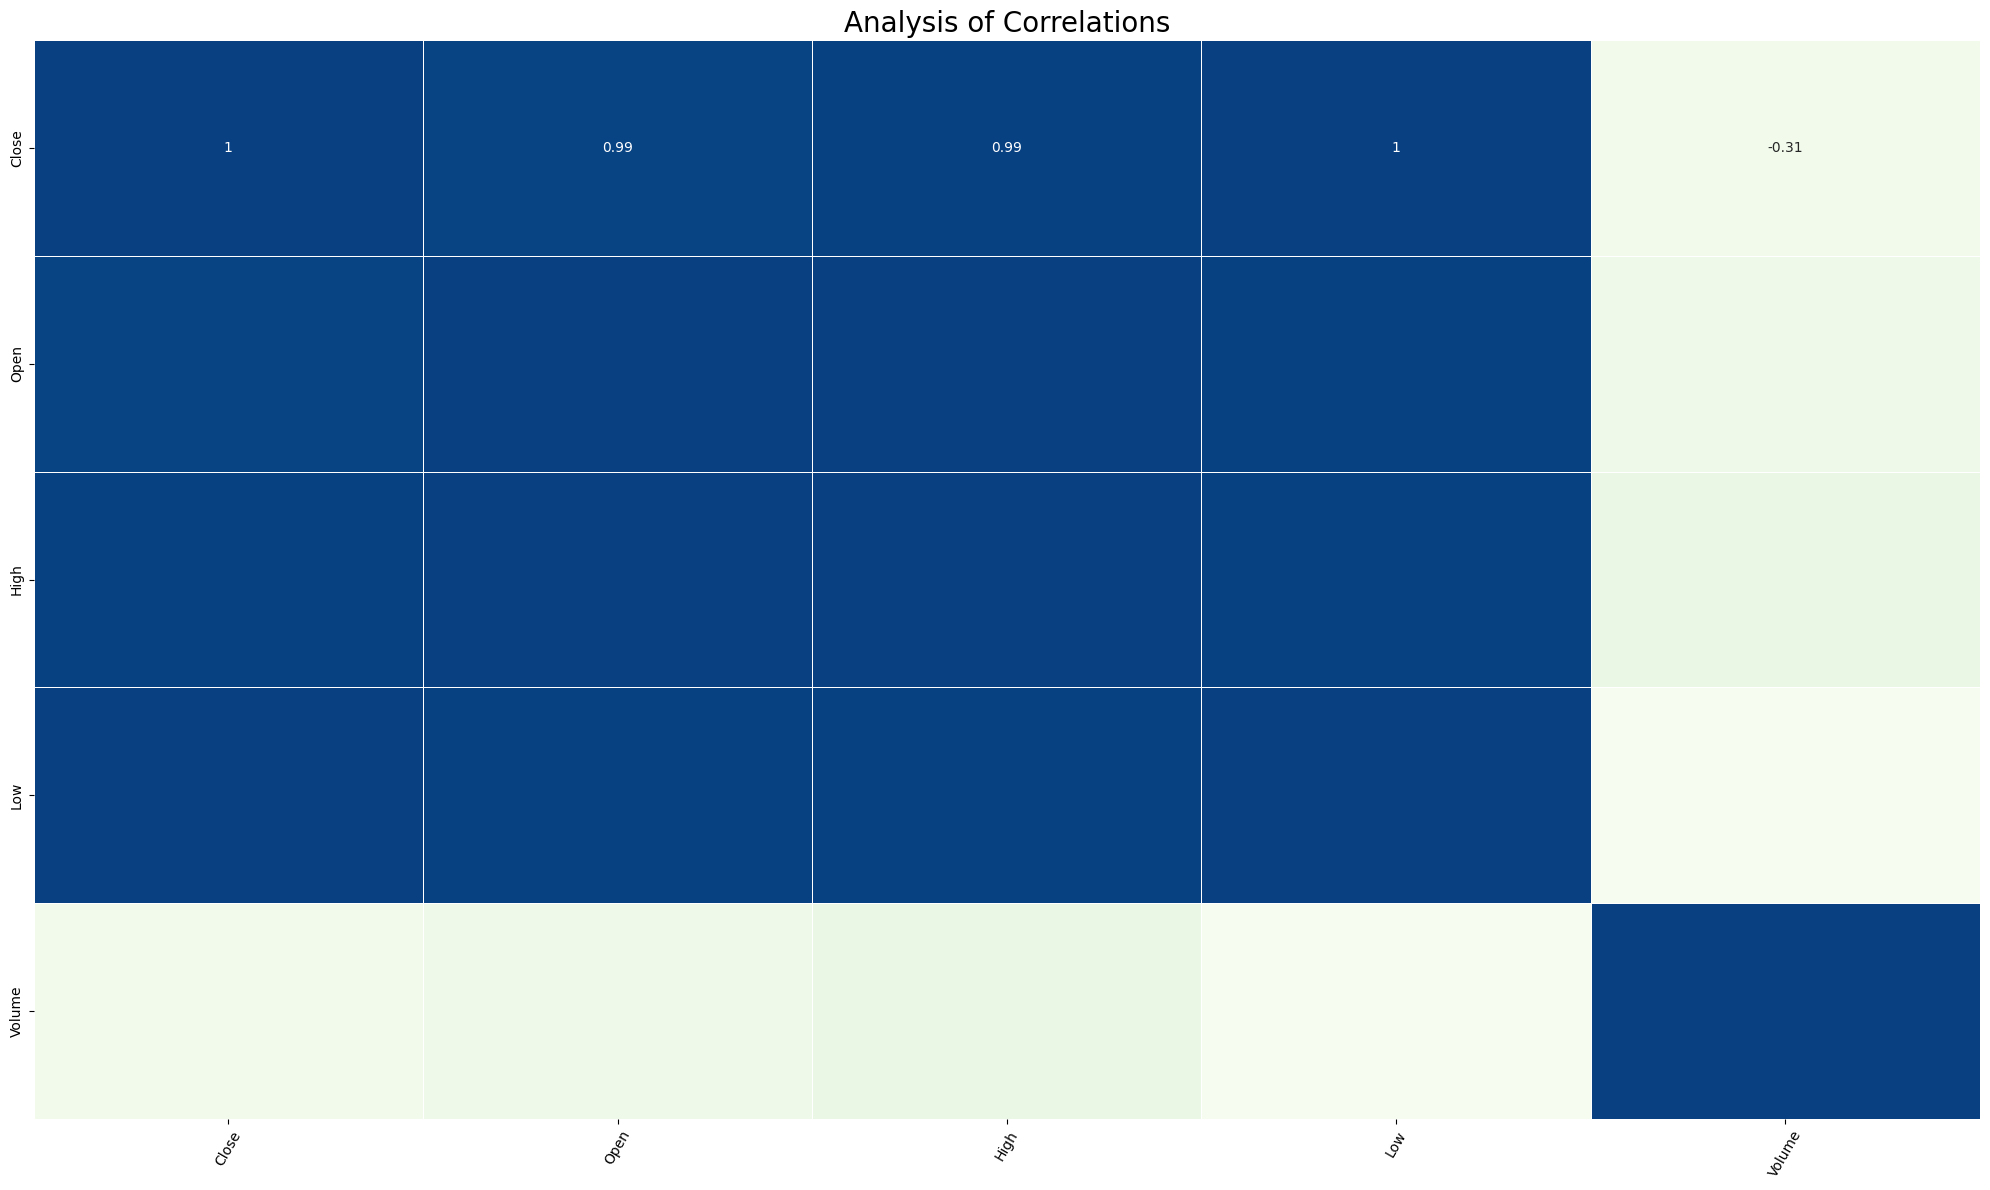

In [406]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="GnBu", annot=True, linewidths=.6 , cbar = False)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()

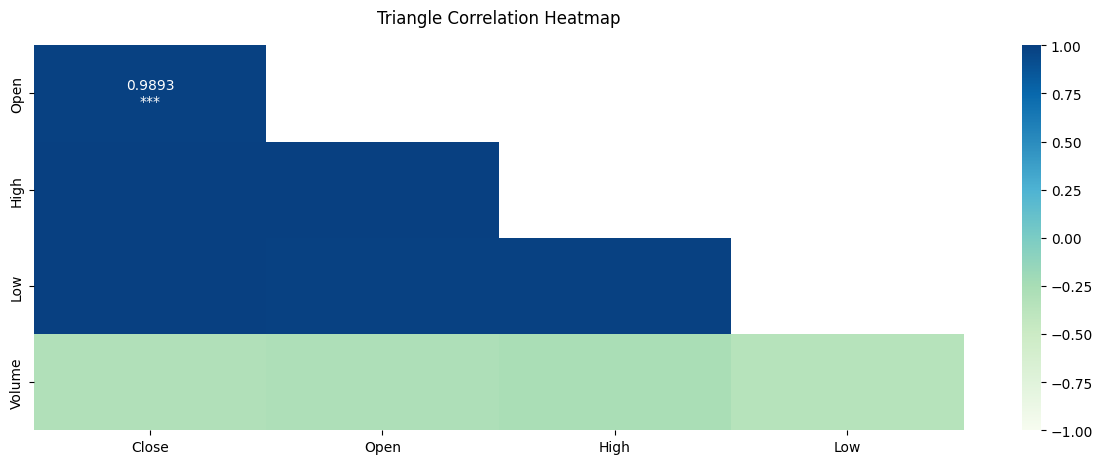

In [407]:
corr = df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='GnBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 12}, pad=16)
plt.show()

<h2>Further analysis confirms strong correlation between prices. However the correlation between them and volume remains weak. It also further confirms multimodal distribution.<h2>

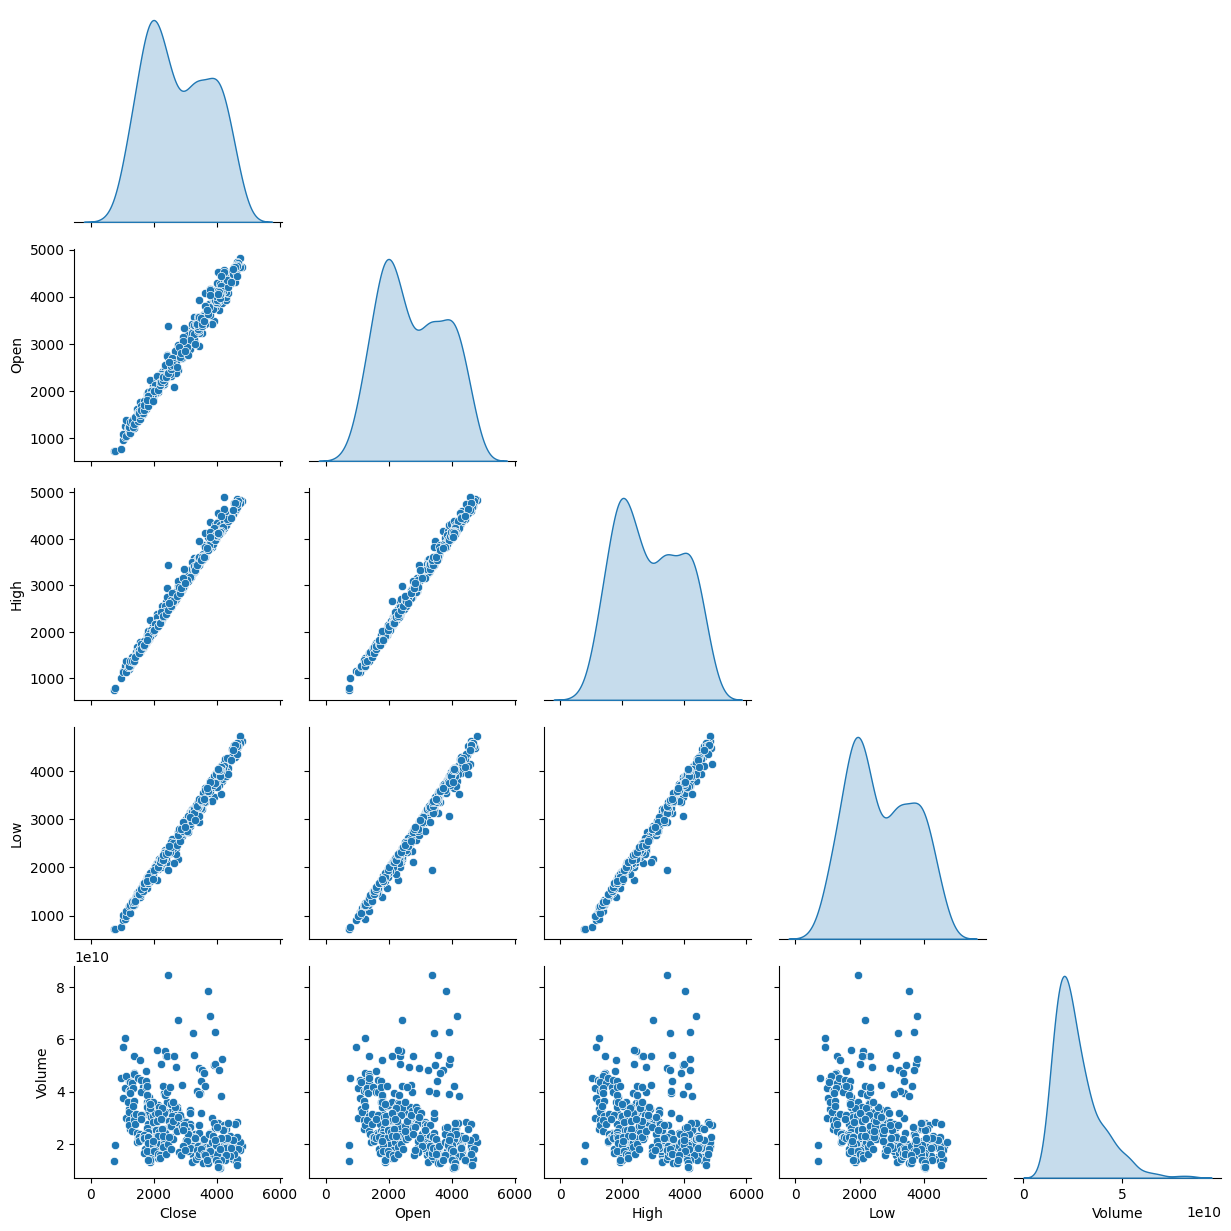

In [408]:
custom_palette = sns.color_palette(['#2a9d8f', '#f4a261'])
sns.pairplot(data=df, diag_kind='kde', palette=custom_palette,corner=True)
plt.gcf().set_facecolor('#ffffff')
plt.show()

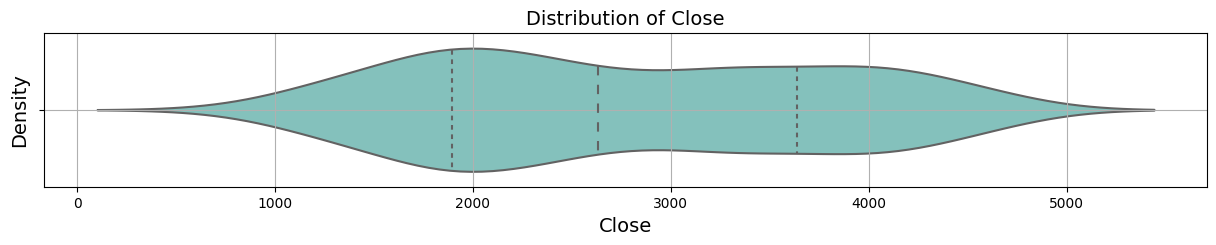

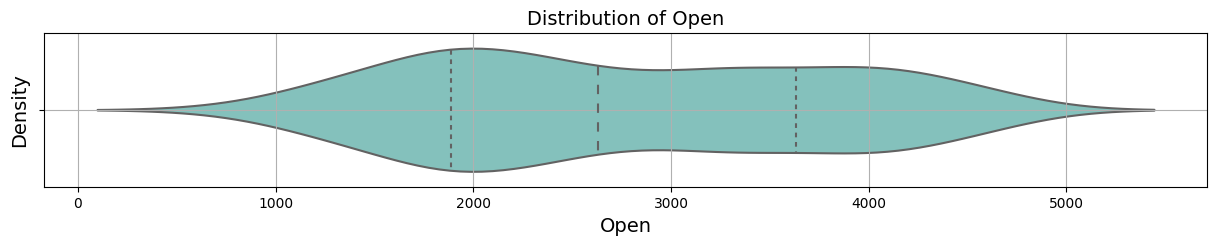

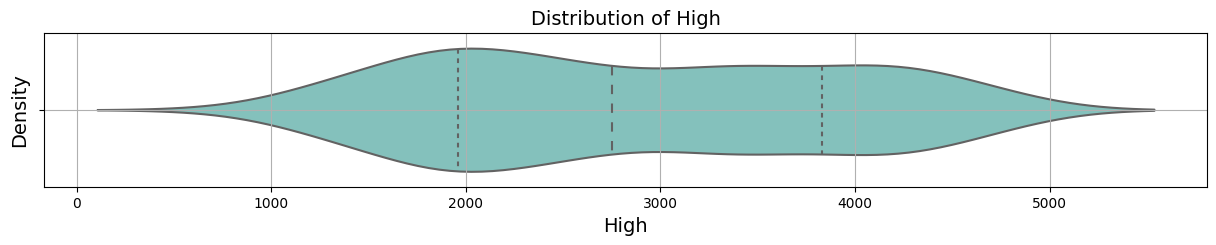

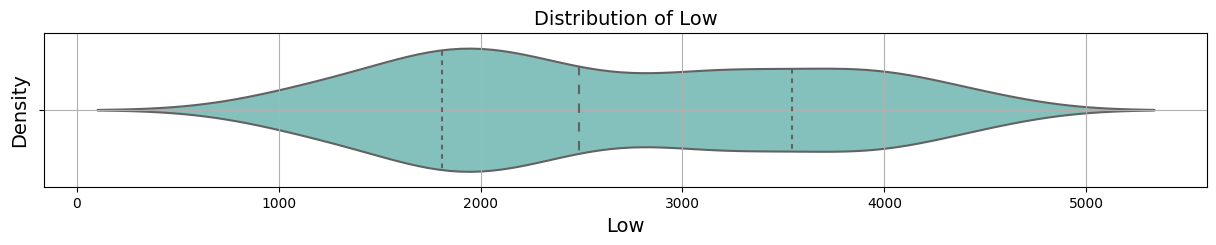

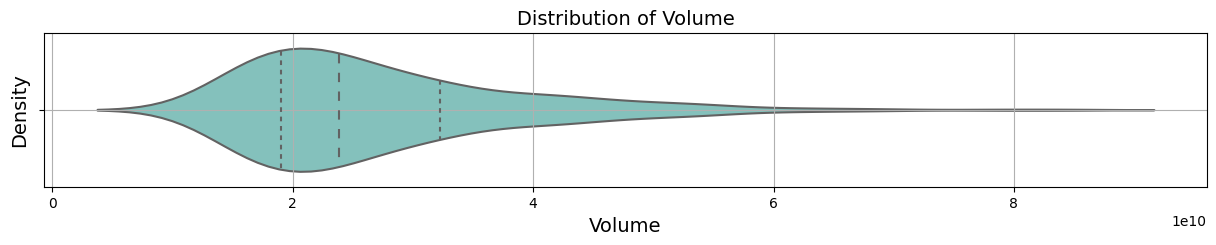

In [409]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.violinplot(x=df[column], palette=palette, inner="quartile")  
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()

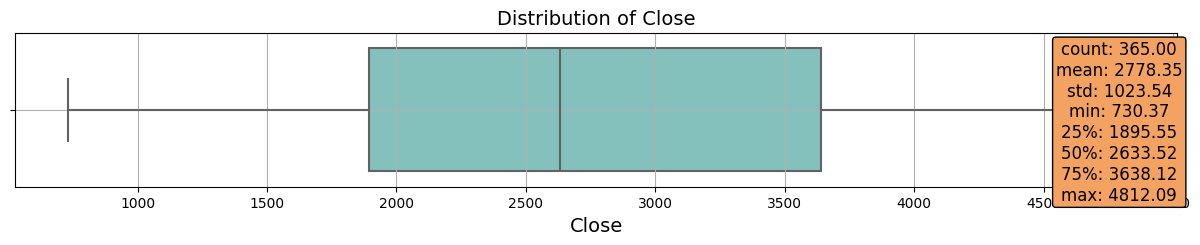

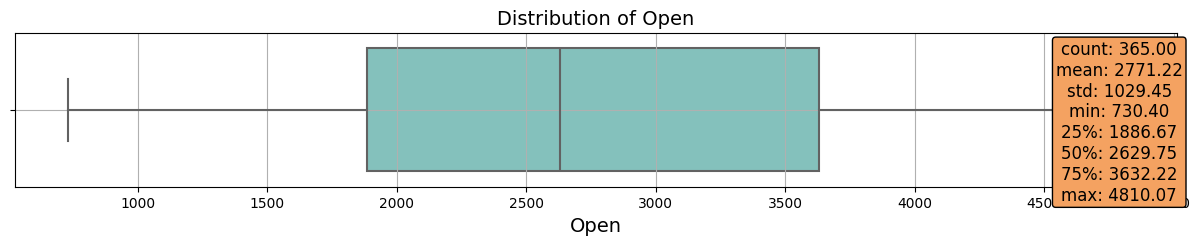

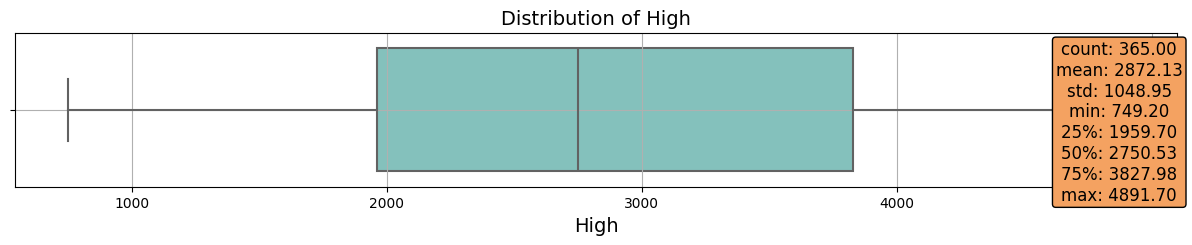

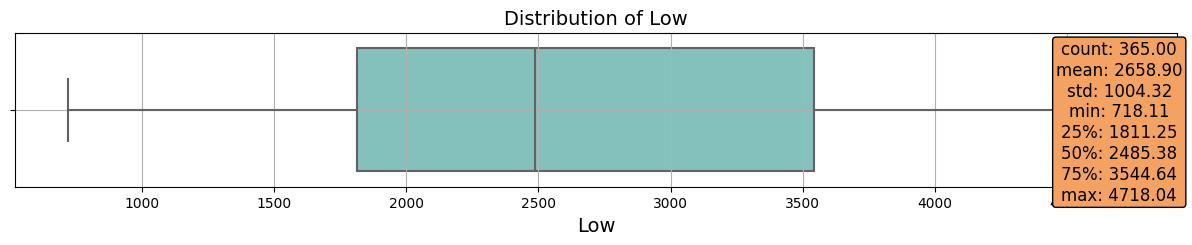

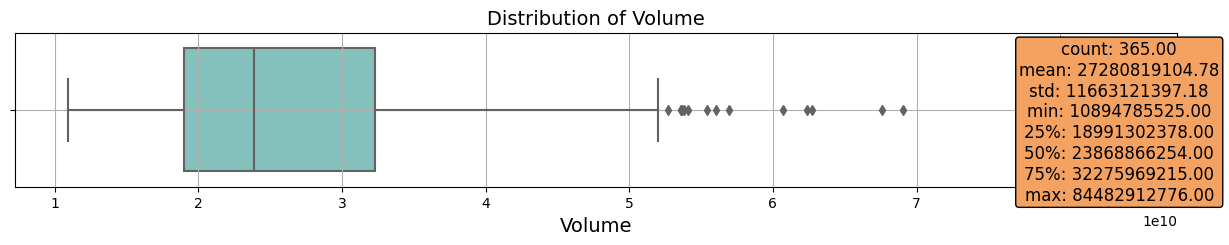

In [410]:
palette = "GnBu" 
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    stats = df[column].describe()
    stats_text = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', 
             horizontalalignment='center', bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='#f4a261'))
    plt.grid(True) 
    plt.show()

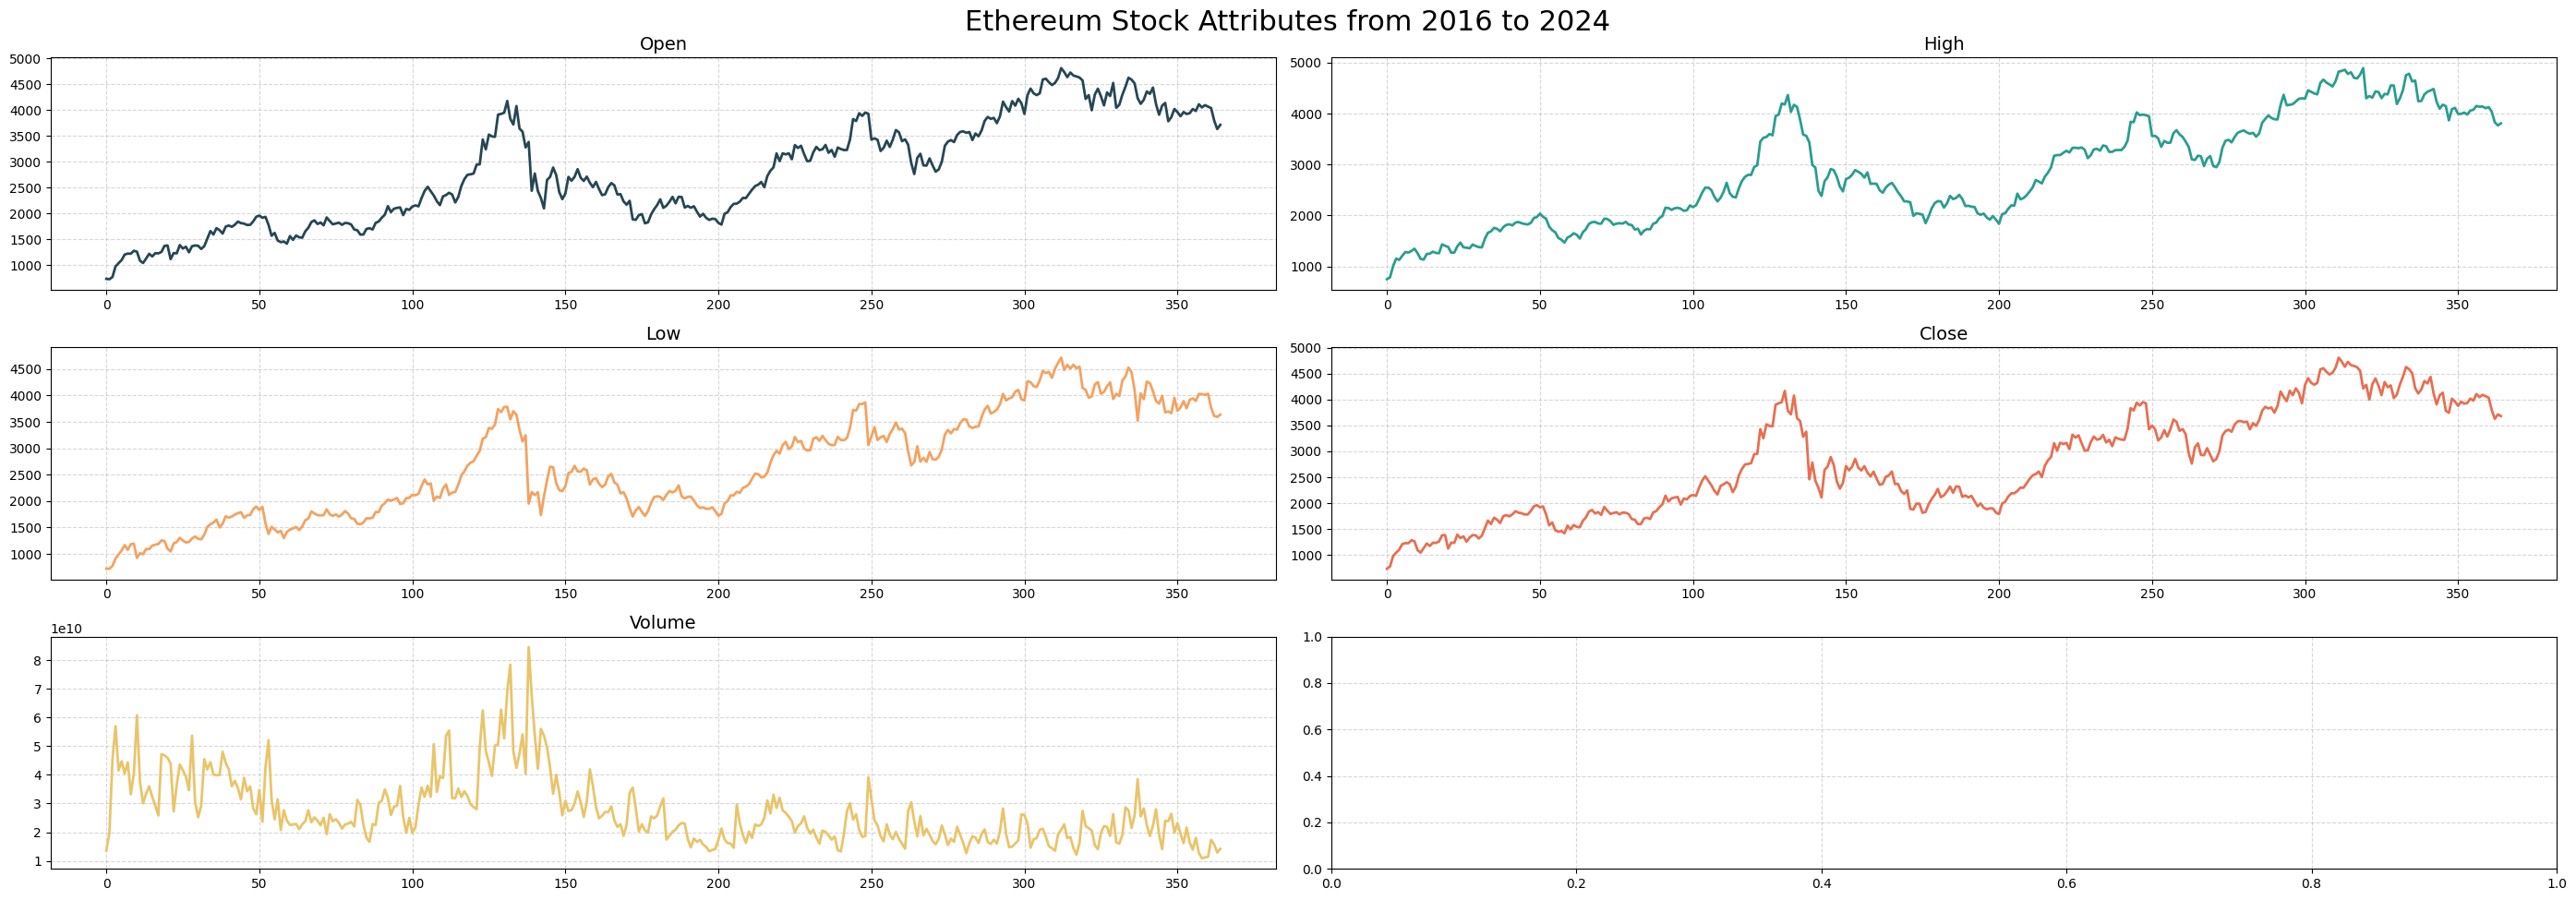

In [411]:
import matplotlib.pyplot as plt
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Ethereum Stock Attributes from 2016 to 2024', fontsize=22, y=0.97)
plt.tight_layout()
plt.show()


In [412]:
df.head()

,Close,Open,High,Low,Volume
0,730.367554,737.708374,749.201843,719.792236,1.365200e+10
1,774.534973,730.402649,786.798462,718.109497,1.974077e+10
2,975.507690,774.511841,1006.565002,771.561646,4.520046e+10
3,1040.233032,977.058838,1153.189209,912.305359,5.694599e+10
4,1100.006104,1041.498779,1129.371460,986.811279,4.153593e+10


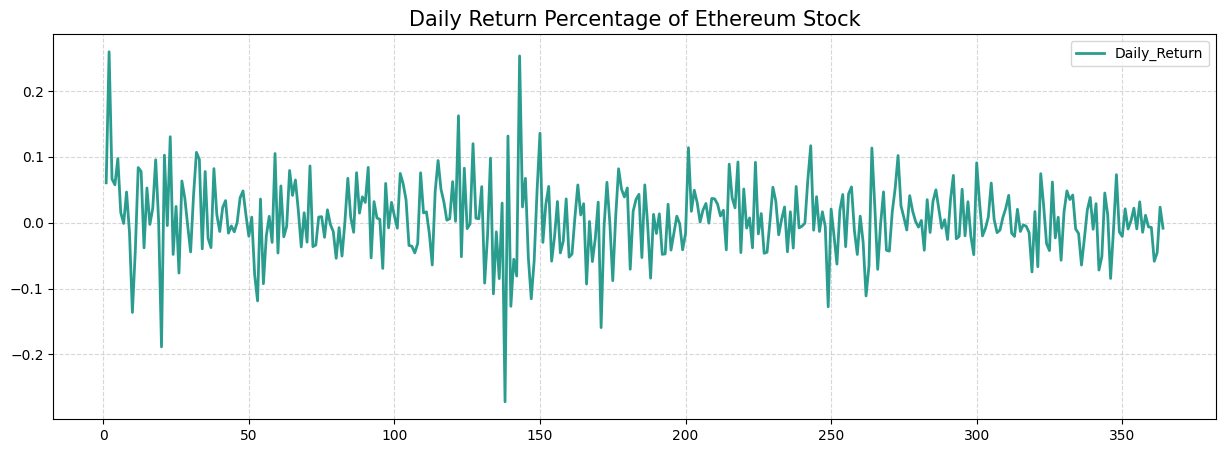

In [413]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].plot(legend=True, figsize=(15, 5), color='#2a9d8f', linewidth=2)
plt.title('Daily Return Percentage of Ethereum Stock', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<h2>Modeling data</h2>

In [414]:
if os.path.isfile('./data/prices/masked_ticker.csv'):
    df5 = pd.read_csv('./data/prices/masked_ticker.csv')
else:
    tck = yf.Ticker("ETH-USD")
    # defining the start date 
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    # historical data
    df5 = tck.history(start=start_date, end=end_date)
    df5 = df5.drop(['Dividends', 'Stock Splits'], axis=1)

In [415]:
df5.head(5)

,Unnamed: 0.33,Unnamed: 0.32,Unnamed: 0.31,Unnamed: 0.30,Unnamed: 0.29,Unnamed: 0.28,Unnamed: 0.27,Unnamed: 0.26,Unnamed: 0.25,Unnamed: 0.24,Unnamed: 0.23,Unnamed: 0.22,Unnamed: 0.21,Unnamed: 0.20,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781


In [ ]:
if os.path.isfile('./data/prices/masked_ticker.csv'):
    pass
else:
    df5.to_csv('./data/prices/masked_ticker.csv')

In [417]:
daily_sentiment = pd.read_csv('./data/sentiment_processed/daily_sentiment.csv')
hourly_sentiment = pd.read_csv('./data/sentiment_processed/hourly_sentiment.csv')

daily_sentiment.tail()

,publication date,mean_VADER,trade_sign
300,2021-10-28,-0.439282,-1
301,2021-10-29,-0.332301,-1
302,2021-10-30,-0.482162,-1
303,2021-10-31,-0.459934,-1
304,2021-11-01,-0.039773,-1


In [418]:
df5 = df5.reset_index()

In [419]:
df5['Volume'] = df5['Volume'].astype('float64')

<h2>Using indicators to further analyse the data</h2>

In [421]:
def get_tech_ind(data):
    data['MA5'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA10'] = data.iloc[:,4].rolling(window=10).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bands
    data['8SD'] = data.iloc[:, 4].rolling(8).std()
    data['upper_band'] = data['MA10'] + (data['8SD'] * 2)
    data['lower_band'] = data['MA10'] - (data['8SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    return data

In [422]:
start_date = '2021-01-01'
end_date = '2021-11-02'

mask = (df5['Date'] >= start_date) & (df5['Date'] < end_date)

df5 = df5.loc[mask]

In [423]:
df5.tail(3)

,index,Unnamed: 0.33,Unnamed: 0.32,Unnamed: 0.31,Unnamed: 0.30,Unnamed: 0.29,Unnamed: 0.28,Unnamed: 0.27,Unnamed: 0.26,Unnamed: 0.25,Unnamed: 0.24,Unnamed: 0.23,Unnamed: 0.22,Unnamed: 0.21,Unnamed: 0.20,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date,Open,High,Low,Close,Volume
302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,302,2021-10-30 00:00:00+00:00,4414.243652,4426.848633,4252.494141,4325.650391,1.461549e+10
303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,2021-10-31 00:00:00+00:00,4322.744141,4394.449707,4179.016113,4288.074219,1.749816e+10
304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,2021-11-01 00:00:00+00:00,4288.217285,4377.322266,4160.966797,4324.626953,1.798529e+10


<h2>Appending the data from sentiment analysis file we export into the other folder.</h2>

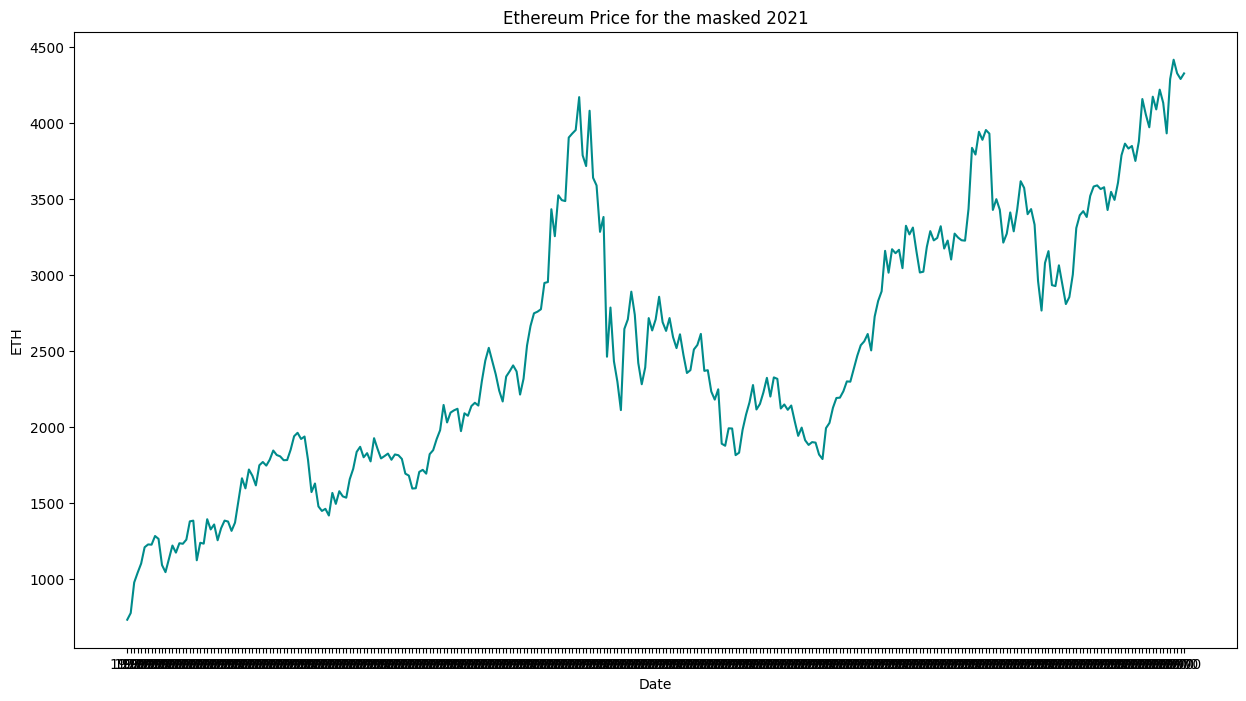

In [424]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df5['Date'], df5['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="ETH", title="Ethereum Price for the masked 2021")

ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.show()

In [426]:
tech_df = get_tech_ind(df5)
dataset = tech_df.iloc[10:,:].reset_index(drop=True)
dataset.head()

,index,Unnamed: 0.33,Unnamed: 0.32,Unnamed: 0.31,Unnamed: 0.30,Unnamed: 0.29,Unnamed: 0.28,Unnamed: 0.27,Unnamed: 0.26,Unnamed: 0.25,Unnamed: 0.24,Unnamed: 0.23,Unnamed: 0.22,Unnamed: 0.21,Unnamed: 0.20,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,7.0,5.5,0.225698,2.44949,10.398979,0.601021,9.500062
1,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,8.0,6.5,0.028653,2.44949,11.398979,1.601021,10.500023
2,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,9.0,7.5,-0.181098,2.44949,12.398979,2.601021,11.500008
3,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,10.0,8.5,-0.399959,2.44949,13.398979,3.601021,12.500003
4,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,11.0,9.5,-0.624921,2.44949,14.398979,4.601021,13.500001


In [430]:
daily_sentiment = daily_sentiment.rename(columns={"publication date": "Date"})

In [431]:
df5['Date'] = pd.to_datetime(df5['Date'], utc=True)

In [432]:
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], utc=True)

In [ ]:
df5 = df5.drop([['Unnamed: 0', 'Unnamed: 0.33', 'Unnamed: 0.32', 'Unnamed: 0.31', 'Unnamed: 0.30', 'Unnamed: 0.29', 'Unnamed: 0.28', 'Unnamed: 0.27', 'Unnamed: 0.26', 'Unnamed: 0.25', 'Unnamed: 0.24', 'Unnamed: 0.23', 'Unnamed: 0.22', 'Unnamed: 0.21', 'Unnamed: 0.20', 'Unnamed: 0.19', 'Unnamed: 0.18', 'Unnamed: 0.17', 'Unnamed: 0.16', 'Unnamed: 0.15', 'Unnamed: 0.14', 'Unnamed: 0.13', 'Unnamed: 0.12', 'Unnamed: 0.11', 'Unnamed: 0.10', 'Unnamed: 0.9', 'Unnamed: 0.8', 'Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1']], axis=1)
print(df5.dtypes, daily_sentiment.dtypes)

index                          int64
Unnamed: 0.33                  int64
Unnamed: 0.32                  int64
Unnamed: 0.31                  int64
Unnamed: 0.30                  int64
Unnamed: 0.29                  int64
Unnamed: 0.28                  int64
Unnamed: 0.27                  int64
Unnamed: 0.26                  int64
Unnamed: 0.25                  int64
Unnamed: 0.24                  int64
Unnamed: 0.23                  int64
Unnamed: 0.22                  int64
Unnamed: 0.21                  int64
Unnamed: 0.20                  int64
Unnamed: 0.19                  int64
Unnamed: 0.18                  int64
Unnamed: 0.17                  int64
Unnamed: 0.16                  int64
Unnamed: 0.15                  int64
Unnamed: 0.14                  int64
Unnamed: 0.13                  int64
Unnamed: 0.12                  int64
Unnamed: 0.11                  int64
Unnamed: 0.10                  int64
Unnamed: 0.9                   int64
Unnamed: 0.8                   int64
U

<h2>Combining Stock Prices, VADER Score and Mean Average</h2>

In [434]:
final_df = df5.merge(daily_sentiment, how="right", on="Date")
final_df['8SD']
final_df.head(9)

,index,Unnamed: 0.33,Unnamed: 0.32,Unnamed: 0.31,Unnamed: 0.30,Unnamed: 0.29,Unnamed: 0.28,Unnamed: 0.27,Unnamed: 0.26,Unnamed: 0.25,Unnamed: 0.24,Unnamed: 0.23,Unnamed: 0.22,Unnamed: 0.21,Unnamed: 0.20,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA,mean_VADER,trade_sign
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,1.365200e+10,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.041249,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,1.974077e+10,NaN,NaN,0.365385,NaN,NaN,NaN,0.750000,0.107192,1
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,4.520046e+10,NaN,NaN,0.613387,NaN,NaN,NaN,1.615385,-0.386431,-1
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,5.694599e+10,NaN,NaN,0.763997,NaN,NaN,NaN,2.550000,-0.602764,-1
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,4.153593e+10,NaN,NaN,0.834107,NaN,NaN,NaN,3.520661,-0.070846,-1
5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,2021-01-06 00:00:00+00:00,1101.005005,1209.428589,1064.233398,1207.112183,4.469991e+10,NaN,NaN,0.837990,NaN,NaN,NaN,4.508242,-0.029554,-1
6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,2021-01-07 00:00:00+00:00,1208.078369,1282.579590,1167.443115,1225.678101,4.046803e+10,3.0,NaN,0.787696,NaN,NaN,NaN,5.503202,-0.366284,-1
7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,2021-01-08 00:00:00+00:00,1225.967896,1273.827515,1076.081543,1224.197144,4.433483e+10,4.0,NaN,0.693397,2.44949,NaN,NaN,6.501220,-0.170553,-1
8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,2021-01-09 00:00:00+00:00,1223.740479,1303.871826,1182.270386,1281.077271,3.323311e+10,5.0,NaN,0.563669,2.44949,NaN,NaN,7.500457,-0.031420,-1


<h2>Visualize the indicators</h2>

In [435]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA5'], label='Moving Average (5 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA10'], label='Moving Average (10 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['8SD'], label='Moving Average (8 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['EMA'], label='Exponential Moving Average (8 days)', color='r', linestyle='-.')
    
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

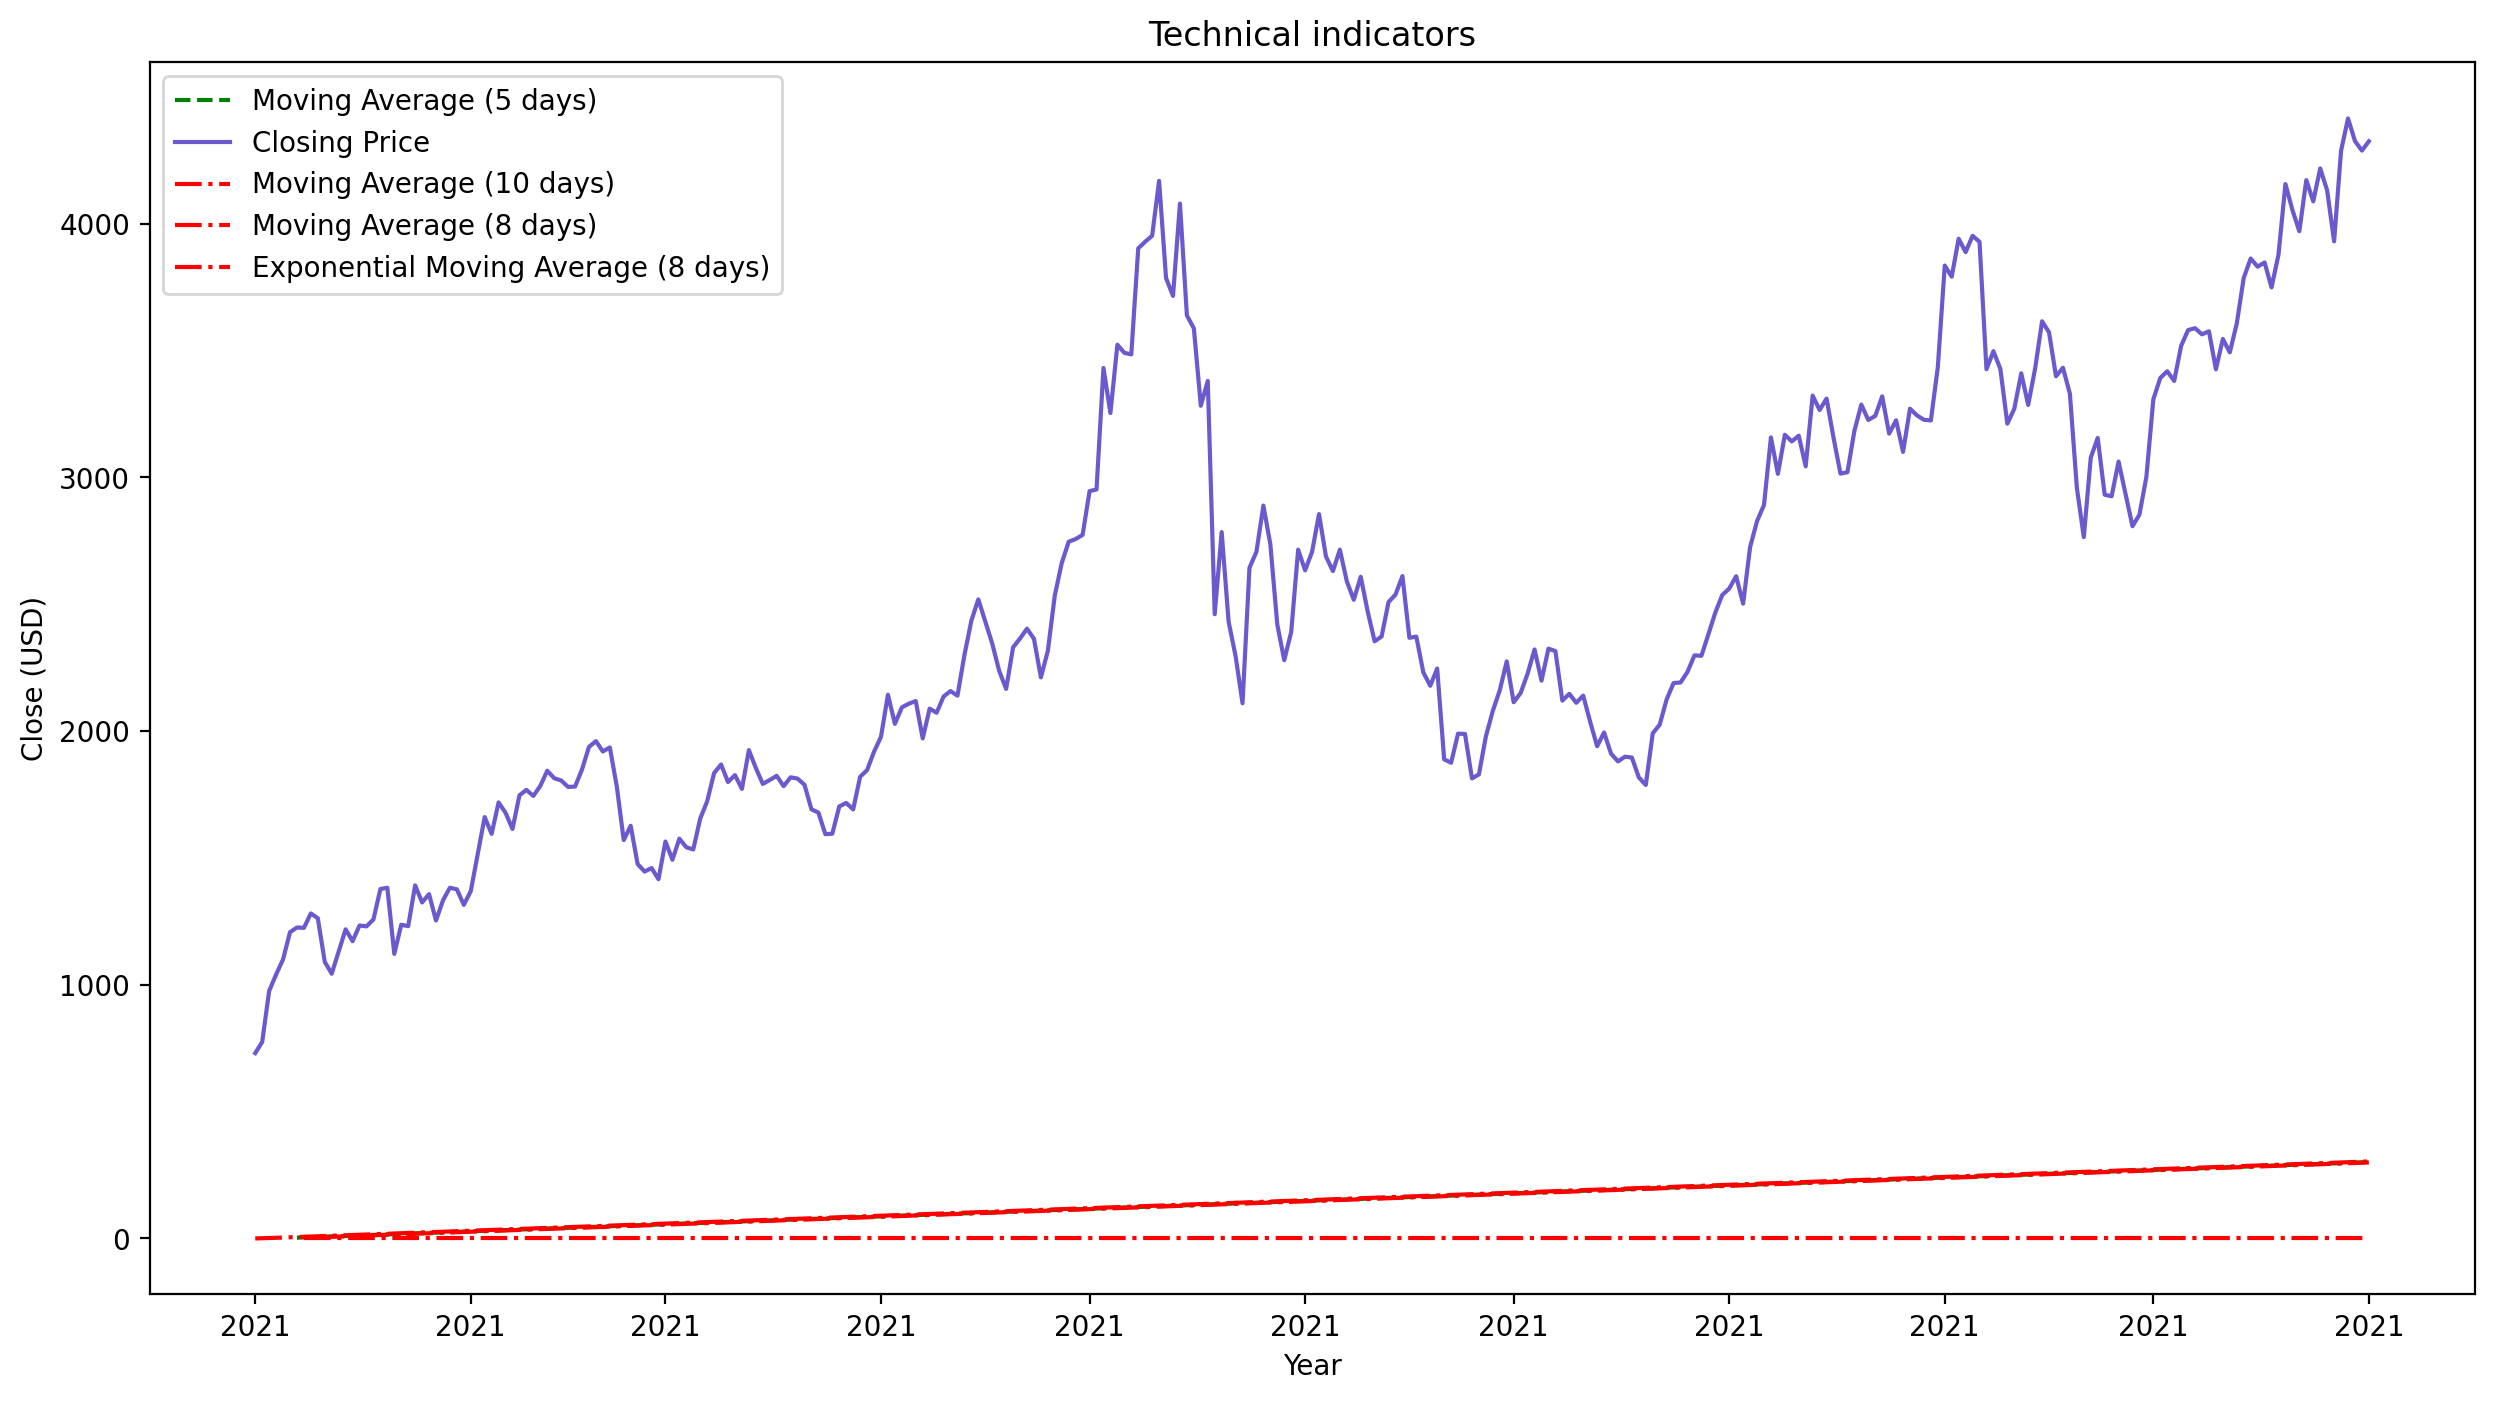

In [436]:
tech_ind(final_df)

<h3>5 days and 10 days dataset copy</h3>

In [437]:
dataset_5_days = final_df.iloc[6:,:].reset_index(drop=True)
dataset_5_days.head()

,index,Unnamed: 0.33,Unnamed: 0.32,Unnamed: 0.31,Unnamed: 0.30,Unnamed: 0.29,Unnamed: 0.28,Unnamed: 0.27,Unnamed: 0.26,Unnamed: 0.25,Unnamed: 0.24,Unnamed: 0.23,Unnamed: 0.22,Unnamed: 0.21,Unnamed: 0.20,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA,mean_VADER,trade_sign
0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,2021-01-07 00:00:00+00:00,1208.078369,1282.579590,1167.443115,1225.678101,4.046803e+10,3.0,NaN,0.787696,NaN,NaN,NaN,5.503202,-0.366284,-1
1,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,2021-01-08 00:00:00+00:00,1225.967896,1273.827515,1076.081543,1224.197144,4.433483e+10,4.0,NaN,0.693397,2.44949,NaN,NaN,6.501220,-0.170553,-1
2,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,2021-01-09 00:00:00+00:00,1223.740479,1303.871826,1182.270386,1281.077271,3.323311e+10,5.0,NaN,0.563669,2.44949,NaN,NaN,7.500457,-0.031420,-1
3,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,2021-01-10 00:00:00+00:00,1280.871094,1347.926147,1194.715576,1262.246704,4.061694e+10,6.0,4.5,0.405742,2.44949,9.398979,-0.398979,8.500169,-0.634428,-1
4,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,7.0,5.5,0.225698,2.44949,10.398979,0.601021,9.500062,-0.418307,-1


In [438]:
dataset_10_days = final_df.iloc[11:,:].reset_index(drop=True)
dataset_10_days.head()

,index,Unnamed: 0.33,Unnamed: 0.32,Unnamed: 0.31,Unnamed: 0.30,Unnamed: 0.29,Unnamed: 0.28,Unnamed: 0.27,Unnamed: 0.26,Unnamed: 0.25,Unnamed: 0.24,Unnamed: 0.23,Unnamed: 0.22,Unnamed: 0.21,Unnamed: 0.20,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA,mean_VADER,trade_sign
0,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,8.0,6.5,0.028653,2.44949,11.398979,1.601021,10.500023,-0.487719,-1
1,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,9.0,7.5,-0.181098,2.44949,12.398979,2.601021,11.500008,-0.117149,-1
2,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,10.0,8.5,-0.399959,2.44949,13.398979,3.601021,12.500003,-0.368219,-1
3,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,11.0,9.5,-0.624921,2.44949,14.398979,4.601021,13.500001,-0.542818,-1
4,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,2021-01-16 00:00:00+00:00,1171.443115,1290.053589,1157.623779,1233.537598,3.231924e+10,12.0,10.5,-0.853477,2.44949,15.398979,5.601021,14.500000,-0.266410,-1


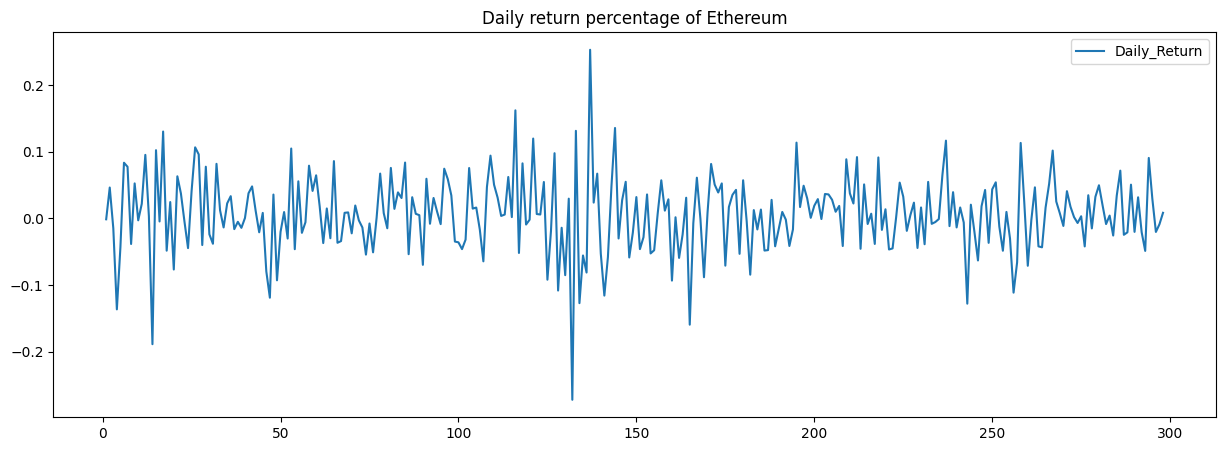

In [439]:
dataset_5_days['Daily_Return'] = dataset_5_days['Close'].pct_change()
# plot the daily return percentage
dataset_5_days.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Ethereum')
plt.show()

<h2>Final Data Preparation</h2>
<h3>Change values for data training</h3>

In [440]:
dataset_5_days_trade_sign = dataset_5_days[['Open', 'Close', 'High', 'Low', 'trade_sign']]

In [441]:
#dataset_5_days_VADER = dataset_5_days[['Open', 'Close', 'High', 'Low', 'mean_VADER']]

In [442]:
# normalize 5 days data
scaler = MinMaxScaler(feature_range=(-1,1)).fit(dataset_5_days_trade_sign)

data_5_days_trade_sign = scaler.transform(dataset_5_days_trade_sign)
print(data_5_days_trade_sign)

[[-0.90248493 -0.89188569 -0.9107357  -0.85507255 -1.        ]
 [-0.89186958 -0.89276426 -0.91600581 -0.90966917 -1.        ]
 [-0.8931913  -0.85902064 -0.89791444 -0.84621194 -1.        ]
 ...
 [ 1.          0.9471445   0.98260568  0.98851831 -1.        ]
 [ 0.94570572  0.92485278  0.96309646  0.94460869 -1.        ]
 [ 0.92521806  0.94653735  0.95278307  0.93382262 -1.        ]]


<h2>5 day long sequences</h2>

In [443]:
seq_len_5_days=6
sequences_5_days_trade_sign=[]
for index in range(len(data_5_days_trade_sign) - seq_len_5_days + 1): 
    sequences_5_days_trade_sign.append(data_5_days_trade_sign[index: index + seq_len_5_days])
sequences_5_days_trade_sign = np.array(sequences_5_days_trade_sign)

sequences_5_days_trade_sign

array([[[-0.90248493, -0.89188569, -0.9107357 , -0.85507255,
         -1.        ],
        [-0.89186958, -0.89276426, -0.91600581, -0.90966917,
         -1.        ],
        [-0.8931913 , -0.85902064, -0.89791444, -0.84621194,
         -1.        ],
        [-0.85929094, -0.8701917 , -0.87138686, -0.83877484,
         -1.        ],
        [-0.87071249, -0.97228924, -0.92335488, -1.        ,
         -1.        ],
        [-0.97342487, -1.        , -0.99102683, -0.9475069 ,
         -1.        ]],

       [[-0.89186958, -0.89276426, -0.91600581, -0.90966917,
         -1.        ],
        [-0.8931913 , -0.85902064, -0.89791444, -0.84621194,
         -1.        ],
        [-0.85929094, -0.8701917 , -0.87138686, -0.83877484,
         -1.        ],
        [-0.87071249, -0.97228924, -0.92335488, -1.        ,
         -1.        ],
        [-0.97342487, -1.        , -0.99102683, -0.9475069 ,
         -1.        ],
        [-1.        , -0.94820722, -1.        , -0.95839203,
         -1. 

In [444]:
valid_set_size_percentage_trade_sign = 10 
test_set_size_percentage_trade_sign = 10 

valid_set_size_trade_sign = int(np.round(valid_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))  
test_set_size_trade_sign  = int(np.round(test_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))
train_set_size_trade_sign = sequences_5_days_trade_sign.shape[0] - (valid_set_size_trade_sign + test_set_size_trade_sign)

x_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,:-1,:]
y_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,-1,:]
    
x_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,:-1,:]
y_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,-1,:]
    
x_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,:-1,:]
y_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,-1,:]

<h2>Building Neural Network and its components with Torch<h2>

In [445]:
x_train_5_days_trade_sign = torch.tensor(x_train_5_days_trade_sign).float()
y_train_5_days_trade_sign = torch.tensor(y_train_5_days_trade_sign).float()

x_valid_5_days_trade_sign = torch.tensor(x_valid_5_days_trade_sign).float()
y_valid_5_days_trade_sign = torch.tensor(y_valid_5_days_trade_sign).float()

train_dataset_5_days_trade_sign = TensorDataset(x_train_5_days_trade_sign, y_train_5_days_trade_sign)
train_dataloader_5_days_trade_sign = DataLoader(train_dataset_5_days_trade_sign, batch_size=32, shuffle=False)

valid_dataset_5_days_trade_sign = TensorDataset(x_valid_5_days_trade_sign, y_valid_5_days_trade_sign)
valid_dataloader_5_days_trade_sign = DataLoader(valid_dataset_5_days_trade_sign, batch_size=32, shuffle=False)

In [446]:
from tqdm.notebook import tqdm
from torchsummary import summary

from torch import nn
class NeuralNetwork(nn.Module):
    #adjust number of features for every new data column
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm    = nn.LSTM(num_feature,64,batch_first=True)
        self.dense   = nn.Linear(64,num_feature)
        self.dropout = nn.Dropout1d(p=0.3) # add to forward pass if needed to test
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        #x = F.relu(self.dense(hidden))
        x = self.dense(hidden)
        return x

model = NeuralNetwork(5)

<h2>Dynamic Network for parameter tuning</h2>
<h3>Aborted</h3>

In [447]:
from tqdm.notebook import tqdm
from torchsummary import summary

from torch import nn
class TuningNeuralNetwork(nn.Module):
    #adjust number of features for every new data column
    def __init__(self, num_feature, Bias=True, Batch_First=True, Num_Layers=1, Dropout=0.0, LBias=True):
        super(NeuralNetwork, self).__init__()
        self.lstm    = nn.LSTM(num_feature, 64, batch_first=Batch_First, bias=Bias, num_layers=Num_Layers, dropout=Dropout)
        self.dense   = nn.Linear(64,num_feature, bias=LBias)
        self.dropout = nn.Dropout1d(p=0.3) # add to forward pass if needed to test
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        #x = F.relu(self.dense(hidden))
        x = self.dense(hidden)
        return x


In [448]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()

In [449]:
summary(model, (5, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  18,176
├─Linear: 1-2                            [-1, 5]                   325
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  18,176
├─Linear: 1-2                            [-1, 5]                   325
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

In [450]:
def train(dataloader):
    epoch_loss = 0
    model.train()
    
    for batch in dataloader:
        optimizer.zero_grad()
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)
        loss.backward()
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [451]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

<h2>Training and Validation comparison plot function</h2>

In [452]:
def plot_loss(train_losses, valid_losses):
    plt.plot(train_losses, color='black', label='test loss')
    plt.plot(valid_losses, color='blue', label='validation loss')

    plt.title('Loss function comparison')
    plt.xlabel('time')
    plt.ylabel('loss values')
    plt.legend(loc='best')
    plt.show()

<h2>Network training loop</h2>

<h3>This code chunk contains code for best fit model</h3>

In [ ]:
#change for different number of iterations
n_epochs = 1300

train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch_instance in range(1, n_epochs + 1):

    train_loss = train(train_dataloader_5_days_trade_sign)
    valid_loss = evaluate(valid_dataloader_5_days_trade_sign)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')
    
    #early stop step - comment out if you want to reach for worse results
    if valid_loss > train_loss:
        break

    print("Epoch ",epoch_instance+1)
    print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

Epoch  2
	Train Loss: 2.51950 | 	Val Loss: 0.28154

Epoch  3
	Train Loss: 2.05426 | 	Val Loss: 0.26463

Epoch  4
	Train Loss: 1.63541 | 	Val Loss: 0.25105

Epoch  5
	Train Loss: 1.28061 | 	Val Loss: 0.23899

Epoch  6
	Train Loss: 1.09178 | 	Val Loss: 0.21046

Epoch  7
	Train Loss: 0.92815 | 	Val Loss: 0.16553

Epoch  8
	Train Loss: 0.74996 | 	Val Loss: 0.12263

Epoch  9
	Train Loss: 0.60220 | 	Val Loss: 0.09227

Epoch  10
	Train Loss: 0.51298 | 	Val Loss: 0.09040

Epoch  11
	Train Loss: 0.51389 | 	Val Loss: 0.10133

Epoch  12
	Train Loss: 0.50865 | 	Val Loss: 0.09671

Epoch  13
	Train Loss: 0.49992 | 	Val Loss: 0.09199

Epoch  14
	Train Loss: 0.49797 | 	Val Loss: 0.09116

Epoch  15
	Train Loss: 0.49567 | 	Val Loss: 0.09188

Epoch  16
	Train Loss: 0.49449 | 	Val Loss: 0.09268

Epoch  17
	Train Loss: 0.49358 | 	Val Loss: 0.09262

Epoch  18
	Train Loss: 0.49256 | 	Val Loss: 0.09222

Epoch  19
	Train Loss: 0.49149 | 	Val Loss: 0.09205

Epoch  20
	Train Loss: 0.49046 | 	Val Loss: 0.09206

E

<h2> Visualization of results</h2>

In [454]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

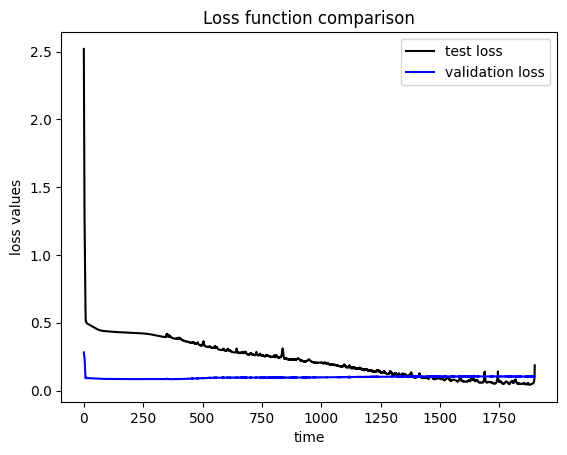

In [455]:
plot_loss(train_losses=train_losses, valid_losses=valid_losses)

<h2>Training with hyperparameters tuning</h2>
<h3>This part is irrelevant and was aborted due to high power demand and slow computations on CPU.</h3>

In [ ]:
def train_hyperparameters(config, data_dir=None):

    hyper_train_losses = []
    hyper_valid_losses = []
    
    hyper_model = TuningNeuralNetwork(5, config['Bias'], config['Batch_First'], config['NL'])

    mse = nn.MSELoss()
    optimizer = optim.Adam(hyper_model.parameters(), lr=config["lr"], momentum=config['mtm'])

    #load checkpoint data in case we want to continue stopped training process
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            hyper_model.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    #change for different number of iterations
    n_epochs = 1300

    best_valid_loss = float('inf')

    for epoch in range(start_epoch, n_epochs + 1):

        train_loss = train(train_dataloader_5_days_trade_sign)
        valid_loss = evaluate(valid_dataloader_5_days_trade_sign)
        
        hyper_train_losses.append(train_loss)
        hyper_valid_losses.append(valid_loss)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model, 'saved_weights.pt')
        
        #early stop step
        if valid_loss > train_loss:
            break

        print("Epoch ",epoch_instance+1)
        print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": hyper_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [ ]:
config = {
    "LBias": tune.choice([True, False]),
    'Bias': tune.choice([True, False]),
    "DO": tune.choice([0.0, 0.1, 0.2, 0.3]),
    "NL": tune.choice([1, 2, 4, 8]),
    "lr": tune.loguniform(1e-5, 1e-1),
    'Batch_First': tune.choice([True, False]),
    'mtm': tune.choice([.0, .2, .4, .6, .8])
}

In [ ]:
num_samples=20

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=n_epochs,
    grace_period=1,
    reduction_factor=2,
)

result = tune.run(
    partial(train_hyperparameters, data_dir=None),
    resources_per_trial={
        "cpu": 4,
        #'gpu': 2  <--- change only if you have gpu for extremely fast calculations
        },
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    checkpoint_at_end=True)

best_trial = result.get_best_trial("loss", 'min')

print(f"Best trial config: {best_trial.config}")

best_trained_model = NeuralNetwork(best_trial.config['Bias'], best_trial.config['Batch_First'], best_trial.config['NL'], best_trial.config['DO'], best_trial.config['LBias'])

best_checkpoint = result.get_best_checkpoint(trial=best_trial, mode="min")
with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    with open(data_path, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

2025-05-16 12:53:30,538	ERROR services.py:1362 -- Failed to start the dashboard , return code 3221226505
2025-05-16 12:53:30,542	ERROR services.py:1387 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2025-05-16 12:53:30,548	ERROR services.py:1397 -- Couldn't read dashboard.log file. Error: 'utf-8' codec can't decode byte 0xb3 in position 31: invalid start byte. It means the dashboard is broken even before it initializes the logger (mostly dependency issues). Reading the dashboard.err file which contains stdout/stderr.
2025-05-16 12:53:30,552	ERROR services.py:1431 -- 
The last 20 lines of C:\Users\X\AppData\Local\Temp\ray\session_2025-05-16_12-53-28_376526_23724\logs\dashboard.err (it contains the error message from the dashboard): 
2025-05-16 12:53:30,744	INFO worker.py:1888 -- S

<h2>Loading saved weights data and conducting Predictions</h2>
<h3>Continued part after skipping the hyperparameter tuning</h3>

In [458]:
model=torch.load('saved_weights.pt', weights_only=False) #set weights_only to False to avoid bug

x_test_5_days_trade_sign= torch.tensor(x_test_5_days_trade_sign).float()

with torch.no_grad():
  y_test_pred_5_days_trade_sign = model(x_test_5_days_trade_sign)

y_test_pred_5_days_trade_sign = y_test_pred_5_days_trade_sign.numpy()[0]

0.16816132378263826
0.19900171250129145


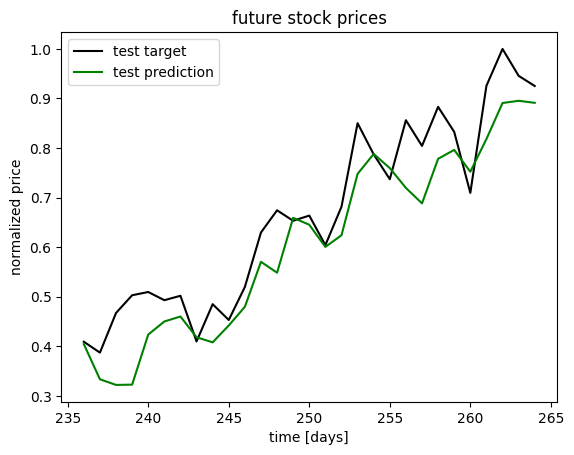

In [459]:
idx=0
plt.plot(np.arange(y_train_5_days_trade_sign.shape[0], y_train_5_days_trade_sign.shape[0]+y_test_5_days_trade_sign.shape[0]),
         y_test_5_days_trade_sign[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train_5_days_trade_sign.shape[0], y_train_5_days_trade_sign.shape[0]+y_test_pred_5_days_trade_sign.shape[0]),
         y_test_pred_5_days_trade_sign[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

print(mean_absolute_error(y_test_5_days_trade_sign, y_test_pred_5_days_trade_sign))
print(mean_absolute_percentage_error(y_test_5_days_trade_sign, y_test_pred_5_days_trade_sign))